In [104]:
import matplotlib.pylab as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats
import numpy as np
import random

In [154]:
NPIs = [ 'Stringency index', 'School closing', 'Workplace closing',
       'Gatherings<br>restrictions', 'Stay home<br>restrictions', 'Cancel events',
        'Internal movement<br>restrictions', "Information campaigns",
       'International movement<br>restrictions', 'Testing policy']
maximum = [5.3, 3.5, 4, 4.2, 2, 2.1, 2.8, 1.2, 3, 1]
maximum2 = [5.3, 3.5, 4, 4.2, 2, 2.1, 2.8, 1.2, 3, 1]

fig = make_subplots(rows=2, cols=5, subplot_titles=NPIs, 
                    x_title="Day", y_title="weight",
                    horizontal_spacing = 0.01)
row, col = 1, 1
for NPI, m, m2 in zip(NPIs, maximum, maximum2):
    ys = []
    x_min = 0.0
    x_max = 16.0 * 2 + 10

    mean = 12
    std = m * 2.1


    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x,mean,std) * std ** 1.3
    
    for i in range(9):
        mean = random.uniform(5, 20)
        std2 = m2 * random.uniform(1, 2)
        y2 = scipy.stats.norm.pdf(x,mean,std2) * std2**random.uniform(1, 1.45)
        fig.add_trace(
            go.Scatter(x=x, y=y2, name=NPI, showlegend=False, marker=dict(color="rgba(25, 25, 25, 0.07)")),
            row=row, col=col, 
        )
        ys.append(y2)
    
    fig.add_trace(
        go.Scatter(x=x, y=np.mean(ys, axis=0), name=NPI, showlegend=False,),
        row=row, col=col, 
    )

#     fig.update_layout(title_text=NPI, row=row, col=col)
    col += 1

    if col % 6 == 0:
        row += 1
        col = 1
    
fig.update_yaxes(showticklabels=False)
fig.update_yaxes(showticklabels=True, row=1, col=1)
fig.update_yaxes(showticklabels=True, row=2, col=1)
fig.update_annotations(font_size=11)
fig.update_yaxes(range=[0, 1])
fig.update_yaxes(fixedrange=True)
fig.update_layout(template="plotly_white", font_family="Arial", 
                  height=400, width=900, 
                  title_text="Computed Weights of every NPI")
fig.show()


In [156]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np


In [157]:
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [159]:
param_values = saltelli.sample(problem, 1000)
Y = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)
Y = Ishigami.evaluate(param_values)

NameError: name 'evaluate_model' is not defined

In [160]:
import os
os.chdir("../LSTM")

In [161]:
from core.nn.LSTMmodel import LSTM

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import math
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import os.path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error
from itertools import cycle

import seaborn as sns
sns.set()
%matplotlib inline

In [162]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [163]:
def get_periods(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
    

def plot_param(df, periods, TARGET):
    fig = px.line(df, x="Date", y=TARGET, title='Lockdown periods in ' + COUNTRY)
    for dates in periods:
        fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
    fig.show()

def add_bias(results, BIAS, isBias=True):
    data = results.copy()
    preds = []
    SIR_data = []
    dates = []
    x_dates, x_preds, total_dates = [], [], []
    x_plot_preds = []
    
    # START Adding bias after days_delay
    BIAS_START = DELAY_START + datetime.timedelta(days_delay)
    for date, pred, index in zip(data["valData"]["Date"], data["pred"], range(0, len(data["valData"]))):
        if date >= BIAS_START:
            preds.append(pred)
            dates.append(date)
            SIR_data.append(SIR_results["I"][index])
        x_dates.append(date)
        x_preds.append(pred)
        total_dates.append(date)
     # Add bias to prediction
    # Calculate trend in SIR-predictions
    x = np.arange(0,len(SIR_data))
    y = np.array(SIR_data)
    if len(y) > 1:
        z = np.polyfit(x, y, 1)[0]
    else:
        z = 1
        
#     plt.plot(x_dates, x_preds)
#     plt.plot(data["valData"]["Date"], data["valData"]["ConfirmedCases"])
#     plt.axvline(BIAS_START, color="black", linestyle="dashed")
    
    new_preds, old_preds = [], []
    weight = 3
    for i in range(len(preds)):
        if i == len(preds) - 1:
            diff = preds[i] - preds[i-1]
        else:
            diff = preds[i + 1] - preds[i]
        percent = (i+1) / days_delay
        weight += 0.1
        if isBias:
            new_trend = (percent * z/weight + diff)
            new_trend = new_trend + diff
            new_preds.append(preds[i] + new_trend)
        else:
            new_preds.append(preds[i])
        old_preds.append(preds[i])
#     plt.plot(dates, new_preds)
#     plt.show()
    if len(y) <= 1:
        new_preds = data["pred"]
    combined_new_preds = new_preds
#     plt.plot(combined_new_preds)
#     plt.show()
    # Add data to results
    data["total_old_pred"] = data["pred"]
    data["pred"] = combined_new_preds
    data["oldpred"] = old_preds
    return data


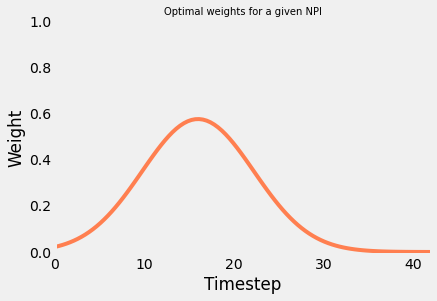

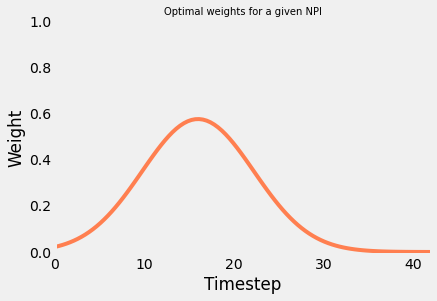

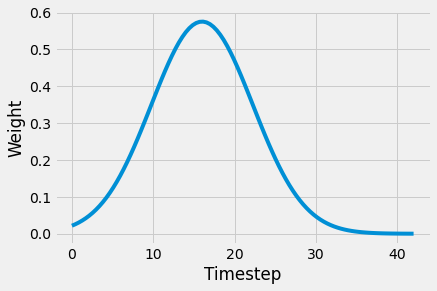

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

delay_days = 16
z = 0.05

x_min = 0.0
buffer = 10
x_max = delay_days * 2 + buffer

mean = delay_days
std = abs(z / 0.008)

x = np.linspace(x_min, x_max, 100)

y = scipy.stats.norm.pdf(x,mean,std) * std**1.2

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)
plt.ylim(-0.01, 1)

plt.title('Optimal weights for a given NPI',fontsize=10)

plt.xlabel('Timestep')
plt.ylabel('Weight')
plt.show()


def plotweights(y):
    plt.plot(x, y)
    plt.xlabel('Timestep')
    plt.ylabel('Weight')
    plt.show()

x, weights = plot_weights(16, .05);
plotweights(weights)

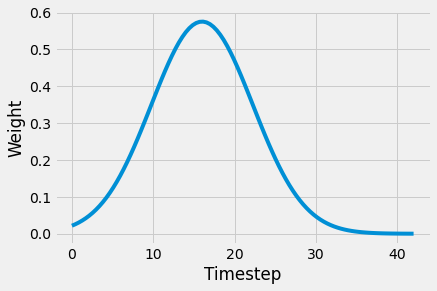

In [110]:
# Select NPI
NPI = "Gatherings_restrictions"
LSTM_predictions, feature_data, SIR_data, weights = [], [], [], []
for day in range(len(SIR_predictions)):
    
    # Compute Gradient instead of using the direct predictions 
    # for scaling/normalizaton purposes
    gradient = get_gradient(SIR_predictions[day + 1], SIR_predictions[day])
    SIR_data.append(gradient)
        
    # Compute trend of NPI
    y = np.array(NPI_data[NPI])
    z = np.polyfit(np.arange(0, len(NPI_data[NPI])), y, 1)[0]
    
    # Compute new weight, where weight is between 0 and 1,
    # if 0, then influence of the SIR model predictions is none, 
    # if 1, then influence of the LSTM model predictions is none.
    weight = compute_weight(z, day, days_delay)
    weights.append(weight)
    
    # Here, the weight of the NPI (z * weight) at timestep i
    # is determined by the delay period (the period between
    # implementing an NPI and the effect on the number of cases).
    result = z * weight
    feature_data.append(result)

# Multivariate LSTM model with SIR based NPI predictions as 
# input feature, along with the number of (previous) 
# confirmed cases (df) and SIR predictions.
model = LSTM(SIR_data=SIR_data, feature=feature_data, input_data=df,
             COUNTRY, TRAIN_UP_TO, FUTURE_DAYS,
             TARGET, TYPE, DELAY_START)
model.fit()
LSTM_pred = model.predict(future_days=FUTURE_DAYS)
plotweights(weights)

In [ ]:
TARGET = "Stringency_index"
TARGET_NPI = TARGET
COUNTRY = "Germany"

NPI_df = oxcgrt_data.cleaned()
NPI_df = NPI_df[NPI_df["Country"] == COUNTRY]

# Get lockdown dates
NPI_df = NPI_df.reset_index().drop('index', axis=1)
NPI_df = NPI_df.groupby("Date").mean().reset_index()

# fig = px.line(NPI_df, x="Date", y=TARGET, title='Periods in ' + COUNTRY)
# for dates in periods:
#     fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
# fig.show()

s = cs.Scenario(jhu_data, population_data, country=COUNTRY)
days_delay, df_periods = s.estimate_delay(oxcgrt_data)
print(f'Delay days: {days_delay}')

NPI = TARGET_NPI
NPI_dates = {}
lockdown_indexes = NPI_df[NPI_df[NPI] >= 75].index
lockdown_dates = NPI_df[NPI_df[NPI] >= 75]["Date"]
periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 65].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 65]["Date"]
    periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 4].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 4]["Date"]
    periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 3].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 3]["Date"]
    periods = get_periods(lockdown_indexes)

lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
NPI_dates[NPI] = lockdown_dates_adjusted

lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
lockdown_dates_adjusted = pd.Series(lockdown_dates_adjusted) 

# Save variable DELAY_START, which is equal to the start of a lockdown period
# in this case, we will hardcode the script to the second lockdown date
# if len(periods) > 2:
DELAY_START = NPI_df.iloc[periods[len(periods) - 1][0]].Date
# else:
#     DELAY_START = NPI_df.iloc[periods[0][0]].Date

df = jhu_data.cleaned()
df = df[(df["Country"] == COUNTRY) & (df["Province"] == "-")]
df["New Confirmed"] = df["Confirmed"].diff()

if COUNTRY == "United Kingdom":
    df_params = pd.read_pickle("df_United_Kingdom")
elif COUNTRY == "China":
    df_params = pd.read_pickle("../figures/pickles/df_China")
else:
    df_params = pd.read_pickle("../figures/pickles/df_9_countries")
df_params["Country"].unique()
df_params = df_params[df_params["Country"] == COUNTRY]
# plot_param(df_params, periods, TARGET="rho")

# DELAY_START = pd.to_datetime('2020-11-06')
TRAIN_UP_TO  = DELAY_START 
print(DELAY_START)


country_df = jhu_data.cleaned()
country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

selection["Confirmed"] = abs(selection["Confirmed"].values[0] - selection["Confirmed"].values[0])
population_df = population_data.cleaned()
N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
selection.head()

target_column = "Confirmed"
if selection["Confirmed"].values[0] == 0:
    target_column = "Infected"

country_df = jhu_data.cleaned()
country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

def calc_param(df, lockdown_dates):
    total_params = ["theta", "kappa", "rho", "sigma"]
    calc_params_df = {}
    for param in total_params:
        values = []
        for date in df["Date"].values:
            if date in lockdown_dates.values:
                values.append(np.mean(df[df['Date'] == date][param]))
        calc_params_df[param] = np.mean(values)
    return calc_params_df

# params = calc_param(df_params, lockdown_dates_adjusted)
params_total = {}
sir_params_total = {}
for p in NPI_dates:
    res = calc_param(df_params, pd.Series(NPI_dates[p]))
    if not math.isnan(res["kappa"]):
        params_total[p] = res

        sir = SIR(N=N, I0=selection[target_column].values[0], R0=selection["Recovered"].values[0], 
                  beta=res["rho"], gamma=res["theta"],
                 days=85)
        SIR_results = sir.simulate(target="Infected")
        sir_params_total[p] = SIR_results

# -------------------------- LSTM -------------------------#
DEVICE       = 'cpu'
ThreshConf   = 70
ThreshDead   = 20
TARGET       = "New Confirmed"
TYPE         = "LSTMCell"
FUTURE_DAYS  = 5
RUNS         = 1
ERROR_THRESH = 1
#     days_delay   = 16
if TARGET_NPI != "Stringency_index":
    bias_bools   = [True]
else:
    bias_bools = [True, False]

BIAS = sir_params_total[TARGET_NPI]

for WITH_BIAS in bias_bools:
    fname = f"bias_res_{TARGET_NPI}_{WITH_BIAS}_{COUNTRY}.p"
    print(fname)
    results_df = pd.DataFrame(columns=["Date"])

    # Check if dataframe already exists to build up on
    if os.path.isfile(fname):
        results_df = pickle.load(open( fname, "rb" ))
        j = len(results_df.columns)
        RUNS = j + RUNS
    else:
        j = 0

    while j < RUNS:
        print("RUN", j)
        FUTURE_DAYS  = 5
        lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
        results1 = lstm.simulate(ThreshConf=70)
        bias_results = add_bias(results1, BIAS)


        for i in range(1):
            FUTURE_DAYS += 6
            lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
            results2 = lstm.simulate(ThreshConf=70, input_data=bias_results)
            bias_results = add_bias(results2, BIAS, isBias=WITH_BIAS)

        trainData = pd.DataFrame(results2["trainData"])
        new_col = pd.DataFrame(trainData)
        new_col = new_col.set_index("Date")

        if j == 0:
            valDates = pd.Series(results2["valData"]["Date"])
            trainDates = pd.Series(results2["trainData"]["Date"])
            new_dates = trainDates.append(valDates)
            results_df["Date"] = new_dates
            results_df = results_df.set_index("Date")
            trueCases = results1["trainData"].set_index("Date")
            valCases = results1["valData"].set_index("Date")
            results_df["TrueCases"] = trueCases["ConfirmedCases"]
            results_df["valCases"] = valCases["ConfirmedCases"]

        error = results2["error"]

        # Don't save run if there were errors in prediction
        if error > ERROR_THRESH:
            print(error)
            RUNS += 1
        else:
            if j == 0:
                results_df["ConfirmedCases"] = new_col["ConfirmedCases"]
            else:
                new_col = new_col.rename(columns={"ConfirmedCases": "Cases" + str(j)})
                results_df = pd.concat([results_df, new_col["Cases" + str(j)]], axis=1)
        j += 1

        if WITH_BIAS:
            results_df.to_pickle(fname)
        else:
            results_df.to_pickle(fname)


    

2020-12-16 00:00:00
nan
2020-12-16 00:00:00
0.5037682056427002


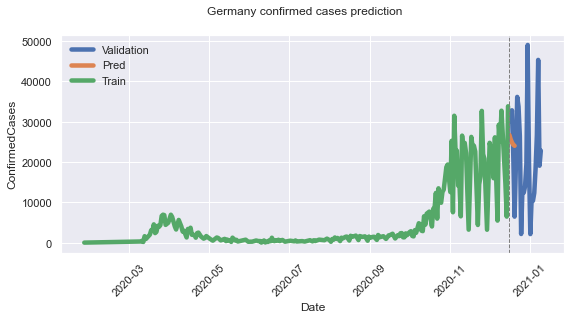

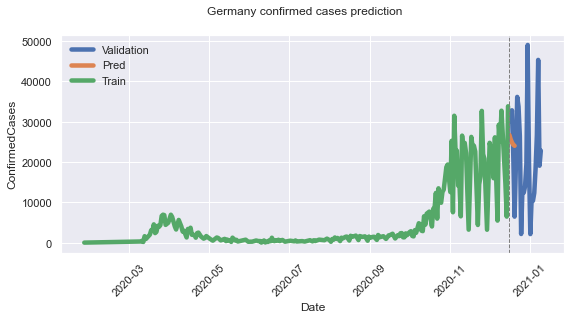

100000000000.0

In [171]:
lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START, show_Figure=True)
results = lstm.simulate(ThreshConf=70)
error = results["error"]
error

In [ ]:
error

In [1110]:
COUNTRY = "Italy"
TARGET_NPI = "Stringency_index"
string = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
string2 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"
TARGET_NPI = "Gatherings_restrictions"
string3 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# string3 = 'bias_res_Gatherings_restrictions_True_Germany.p'
# TARGET_NPI = "School_closing"
# string4 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"

df = pickle.load(open( string, "rb" ))
df_LSTM = pickle.load(open( string2, "rb" ))
df_NPI = pickle.load(open( string3, "rb" ))
# df_NPI = df_NPI.drop(df_NPI.columns, axis=1)
# df_SC = pickle.load(open( string4, "rb" ))
dates = 170
dates_end = 35
df = df[dates: -dates_end]
df = df.reset_index()
df_LSTM = df_LSTM[dates: -dates_end]
df_LSTM = df_LSTM.reset_index()
df_NPI = df_NPI[dates: -dates_end]
df_NPI = df_NPI.reset_index()
# df_SC = df_SC[dates: dates+dates_end]
# df_SC = df_SC.reset_index()

palette = cycle(px.colors.qualitative.G10)
color1 = 'rgba(10, 10, 10, 0.5)'
color2 = 'rgba(21, 178, 211, 0.3)'
color3 = 'rgba(21, 178, 211, 0.8)'
color4 = 'rgba(225, 205, 0, 0.2)'
color5 = 'rgba(255, 215, 0, 0.9)'
color6 = 'red'
color7 = 'rgba(0, 0, 30, 0.25)'
color8 = 'rgba(0, 0, 30, 0.8)'
color9 = 'rgba(0, 180, 30, 0.2)'
color10 = 'rgba(0, 180, 30, 0.8)'

window = 7
rolling = df["valCases"].rolling(window=window).mean().shift(-window + 2)
# rolling2 = df["rueCases"].rolling(window=window).mean().shift(-window + 2)

fig = make_subplots()
fig.add_trace(go.Scatter(showlegend=True, name="7-Day Rolling average", x=df.Date, 
                         y=rolling, line=dict(color=color6, width=4.5)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["valCases"], line=dict(color=color1, width=1)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["TrueCases"], line=dict(color=color1, width=1)))

def _filter(df, df_target, color1, color2, name):
    df_target = df_target[df_target["Date"]  >= DELAY_START]
    drops = []
    
    for i in range(3, len(df_target.columns) - 1): 
        y = df_target[df_target.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, i].dropna()))].valCases
        y = y.dropna()
        pred = df_target.iloc[:, i].dropna()[-len(y):]
        diff = mean_squared_error(y, pred, squared=False)
        average = df_target.iloc[:, 3:].mean(axis=1)
        if diff > 19488:
            drops.append(df_target.columns[i])
            continue
                
        if name == "No restrictions":
            df_target.iloc[:, i] += 5000
        if name == "Gatherings restrictions":
            df_target.iloc[:, i] += 6000
#         else:
#             vals = []
#             x = 100
#             for value in range(len(df_target.iloc[:,i])):
#                 vals.append(df_target.iloc[value,i] - x + random.randint(-10, 700))
#                 x *= 1.1
#             df_target.iloc[:,i] = (vals + rolling[40:]) / 2
#                 df_target.iloc[:, i] = average + random.randint(-1000, 1000) - 5000

    df_target = df_target.drop(df_target[drops], axis=1)
    average = df_target.iloc[:, 3:].mean(axis=1)
    print(len(df_target.columns), name, "RUNS")
    std = df_target.iloc[:, 3:].std(axis=1) 
    average = (df_target.iloc[:, 2] + rolling[90:] + average * 15)  / 17
    df_target["average"] = average
    
    fig.add_trace(go.Scatter(name=name, x=df_target.Date, y=df_target["average"], line=dict(color=color2, width=3)))
    if name == "Gatherings restrictions":
        std = std* 1.1
    if name == "Lockdown":
        std = std * 2
#     elif name == "No restrictions":
#         std = std / 2
    fig.add_trace(go.Scatter(x=df_target.Date,y=average + std,mode='lines',line=dict(width=0),showlegend=False))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average - std,mode='lines',fill='tonexty',fillcolor=color1,line=dict(color='rgba(0,0,0,0)'),hoverinfo="skip",showlegend=False))
      
    
_filter(df, df_LSTM, color4, color5, "No restrictions")
_filter(df, df_NPI, color7, color8, "Gatherings restrictions")
_filter(df, df, color2, color3, "Lockdown") 
# _filter(df, df_SC, color9, color10, "School Closing")


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Confirmed Cases</b>")
fig.update_layout(template="none", autosize=True, width=750, height=500,)
fig.layout.font.family = 'Arial'
fig.add_vline(x=DELAY_START, line_width=1, line_dash="dash", line_color="grey")
fig.add_annotation(x=DELAY_START, y=np.max(df['valCases']), text="Lockdown", showarrow=True, xshift=-20)

fig.show()

11 No restrictions RUNS
7 Gatherings restrictions RUNS
7 Lockdown RUNS


In [218]:
COUNTRY = "Sweden"
# TARGET_NPI = "Stringency_index"
# string = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# string2 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"
TARGET_NPI = "Stringency_index"
string3 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# TARGET_NPI = "School_closing"
string4 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"

# df = pickle.load(open( string, "rb" ))
# df_LSTM = pickle.load(open( string2, "rb" ))
df_NPI = pickle.load(open( string3, "rb" ))
df_SC = pickle.load(open( string4, "rb" ))

dates = 200
dates_end = 1

df_NPI = df_NPI[dates: len(df_NPI)-dates_end]
df_NPI = df_NPI.reset_index()
df_SC = df_SC[dates: len(df_SC)-dates_end]
df_SC = df_SC.reset_index()
df = df_NPI.copy()


palette = cycle(px.colors.qualitative.G10)
color1 = 'rgba(10, 10, 10, 0.5)'
color2 = 'rgba(21, 178, 211, 0.3)'
color3 = 'rgba(21, 178, 211, 0.8)'
color4 = 'rgba(225, 205, 0, 0.2)'
color5 = 'rgba(255, 215, 0, 0.9)'
color6 = 'red'
color7 = 'rgba(0, 0, 30, 0.25)'
color8 = 'rgba(0, 0, 30, 0.8)'
color9 = 'rgba(0, 180, 30, 0.2)'
color10 = 'rgba(0, 180, 30, 0.8)'

window = 7
rolling = df["valCases"].rolling(window=window).mean().shift(-window + 2)
rolling_vals = [value for value in rolling if not math.isnan(value)]

fig = make_subplots()
fig.add_trace(go.Scatter(showlegend=True, name="7-Day Rolling average", x=df.Date, 
                         y=rolling, line=dict(color=color6, width=4.5)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["valCases"], line=dict(color=color1, width=1)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["TrueCases"], line=dict(color=color1, width=1)))

def _filter(df, df_target, color1, color2, name):
    df_target = df_target[df_target["Date"]  >= DELAY_START]
#     display(df_target)
    drops, diffs = [], []
#     y = df[df.Date >= DELAY_START]
    if COUNTRY == "Sweden":
        y = df_target[df_target.Date < DELAY_START + datetime.timedelta(57)].valCases.dropna()
    else:
        y = df_target[df_target.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, 3].dropna()))].valCases
#     y = df.valCases[df.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, 3]))]
    
    print(len(y), len(df_target.iloc[:, 3].dropna()))

    for i in range(3, len(df_target.columns) - 1):  
        pred = df_target.iloc[:, i].dropna()
        diff = mean_squared_error(y, pred, squared=False)
        if diff > 161000:
            drops.append(df_target.columns[i])
#             drops.append(df_target.columns[4])
            continue
        else:
            df_target.iloc[:, i]
            diffs.append(diff)

    df_target = df_target.drop(df_target[drops], axis=1)
    average = df_target.iloc[:, 3:].mean(axis=1)

    std = df_target.iloc[:, 3:].std(axis=1)
#     if name == "Lockdown":
#         average = (df_target.iloc[:, 2] + average * 15 +  df_target.iloc[:, 3]) / 18 + 1000
    df_target["average"] = average
    
    fig.add_trace(go.Scatter(name=name, x=df_target.Date, y=df_target["average"], line=dict(color=color2, width=3)))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average + std / 2,mode='lines',line=dict(width=0),showlegend=False))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average - std / 2 ,mode='lines',fill='tonexty',fillcolor=color1,line=dict(color='rgba(0,0,0,0)'),hoverinfo="skip",showlegend=False))
    return np.sqrt(np.sum(diffs)) / len(average)

error = _filter(df_NPI, df_NPI, color9, color10, "Lockdown")
error = _filter(df_NPI, df_SC, color7, color8, "No restrictions")


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Confirmed Cases</b>")
fig.update_layout(template="none", autosize=True, width=550, height=380,)
fig.layout.font.family = 'Arial'
fig.add_vline(x=DELAY_START, line_width=1, line_dash="dash", line_color="grey")
fig.add_annotation(x=DELAY_START, y=np.max(df['valCases']), text="Lockdown", showarrow=True, xshift=-20)

# fig.update_layout(legend=dict(orientation="h",
#     yanchor="bottom",
#     y=1.02,
#     xanchor="right",
#     x=1
# ))
fig.update_layout(title = dict(text = COUNTRY, y = 0.8), showlegend=True)

fig.show()

0 0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [185]:
DELAY_START + datetime.timedelta(len(df_NPI.iloc[:, 3].dropna()))

Timestamp('2021-02-10 00:00:00')

In [174]:
DELAY_START = pd.to_datetime('2020-12-04')

In [178]:
len(df_NPI.iloc[:, 3].dropna())

68